# Comparing my code and TensorFlow for `lagaris01`

## Introduction

The purpose of this notebook is to provide a comparison between the `nnde` code and TensorFlow for the solution of the `lagaris01` ODE.

## The `lagaris01` problem

This ODE was used as the first example problem in (Lagaris et al., 1998). It has been used in several other papers in the neural network/differential equation literature. The differential equation is provided in the form (equation (27) in Lagaris (1998)):

\begin{equation}
    \frac {d\psi} {dx} + \left (x+\frac {1+3x^2} {1+x+x^3} \right ) \psi =
    x^3 + 2x + x^2 \frac {1+3x^2} {1+x+x^3}
\end{equation}

or:

\begin{equation}
    G\left(x,\psi,\frac {d\psi}{dx}\right) = \frac {d\psi} {dx} + \left (x+\frac {1+3x^2} {1+x+x^3} \right ) \psi - x^3 - 2x - x^2 \frac {1+3x^2} {1+x+x^3} = 0
\end{equation}

The initial condition is:

\begin{equation}
    \psi(0)=1
\end{equation}

The analytical solution is:

\begin{equation}
    \psi_a(x) = x^2 + \frac {e^{-x^2/2}} {1 + x +  x^3}
\end{equation}

The first derivative is:

\begin{equation}
    \frac {d\psi_a} {dx} = 2x - \frac {e^{-x^2/2} (1+x+4x^2+x^4)} {(1+x+x^3)^2}
\end{equation}

The analytical solution and derivative in the domain $[0,1]$ are plotted below.

In [1]:
# Import standard Python modules.
import datetime
from math import exp, sqrt
import matplotlib.pyplot as plt
import numpy as np

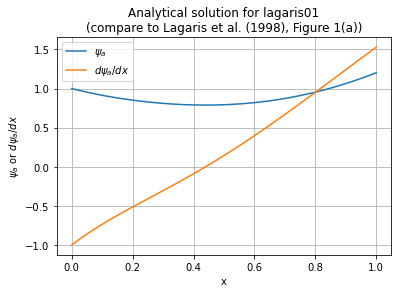

In [2]:
import nnde.differentialequation.examples.lagaris_01 as lagaris01

# Load the equation.
eq_name = "lagaris01"

# Compute the analytical solution and derivative.
na = 101
xa = np.linspace(0, 1, na)
Ya = np.zeros(na)
dYa_dx = np.zeros(na)
for i in range(na):
    Ya[i] = lagaris01.Ya(xa[i])
    dYa_dx[i] = lagaris01.dYa_dx(xa[i])

# Plot the analytical solution and derivative.
plt.plot(xa, Ya, label="$\psi_a$")
plt.plot(xa, dYa_dx, label="$d\psi_a/dx$")
plt.xlabel("x")
plt.ylabel("$\psi_a$ or $d\psi_a/dx$")
plt.grid()
plt.legend()
plt.title("Analytical solution for %s\n(compare to Lagaris et al. (1998), Figure 1(a))" %
         (eq_name));

## Solving `lagaris01` using the `nnde` package

In [3]:
# Load the nnde packages needed for this problem.
from nnde.neuralnetwork.nnode1ivp import NNODE1IVP
from nnde.differentialequation.ode.ode1ivp import ODE1IVP

# Create the training data.
xmin = 0
xmax = 1
nt = 11
xt = np.linspace(xmin, xmax, nt)

# Create the ODE object for the problem.
eq_name = 'nnde.differentialequation.examples.lagaris_01'
ode = ODE1IVP(eq_name)

# Create the network.
H = 10  # Number of hidden nodes
net1 = NNODE1IVP(ode, nhid=H)

# Specify training options.
trainalg = 'delta'
opts = {}
opts["eta"] = 0.01 # Learning rate
opts["maxepochs"] = 1000  # Number of training epochs
opts["b_min"] = -0.1
opts["b_max"] = 0.1
opts["v_min"] = -0.1
opts["v_max"] = 0.1
opts["w_min"] = -0.1
opts["w_max"] = 0.1

# Train the network.
np.random.seed(0)
print(datetime.datetime.now())
%timeit -n 1 -r 1 net1.train(xt, trainalg=trainalg, opts=opts)

2021-06-27 14:13:02.873787
331 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [4]:
# Compute the trained model solution and derivative at the training points.
Ymt = net1.run(xt)
dYmt_dx = net1.run_derivative(xt)

# Compute the analytical solution and derivative at the training points.
Yat = [lagaris01.Ya(x) for x in xt]
dYat_dx = [lagaris01.dYa_dx(x) for x in xt]

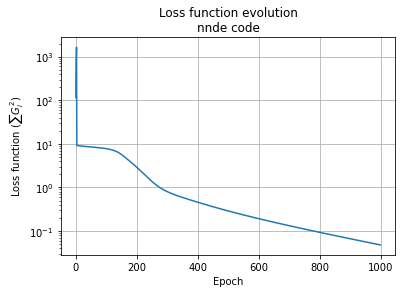

In [5]:
# Plot the loss function history.
plt.semilogy(net1.losses)
plt.xlabel("Epoch")
plt.ylabel("Loss function ($\sum G_i^2$)")
plt.grid()
plt.title("Loss function evolution\nnnde code")
plt.show()

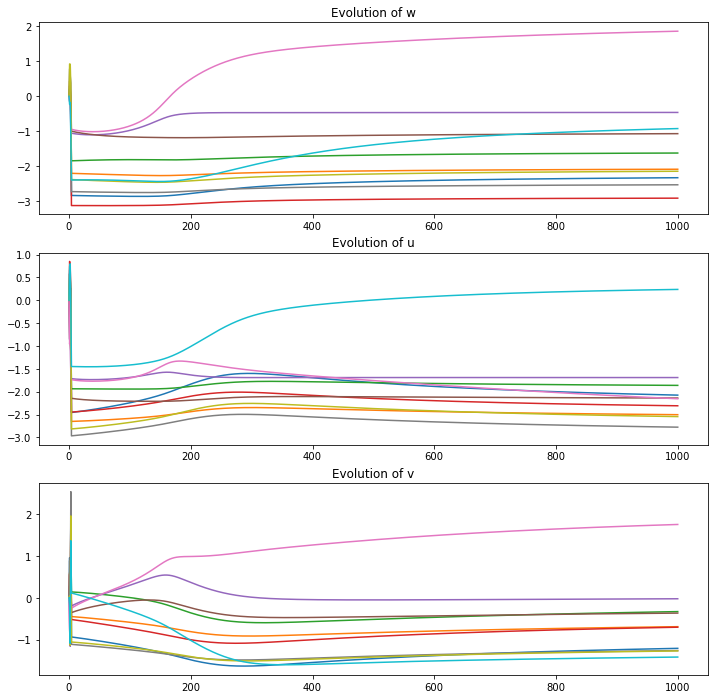

In [6]:
# Plot the parameter histories.
plt.figure(figsize=(12, 12))

# w
plt.subplot(311)
plt.plot(net1.phist[:, 0:10])
plt.title("Evolution of w")

# u
plt.subplot(312)
plt.plot(net1.phist[:, 10:20])
plt.title("Evolution of u")

# v
plt.subplot(313)
plt.plot(net1.phist[:, 20:30])
plt.title("Evolution of v")

plt.show()

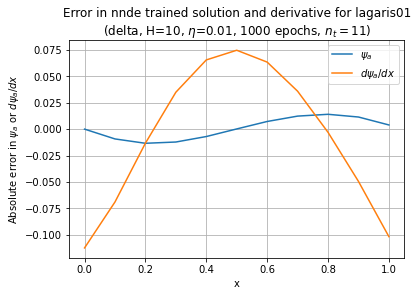

In [7]:
# Plot the errors in the analytical solution and derivative.
plt.plot(xt, Ymt - Yat, label="$\psi_a$")
plt.plot(xt, dYmt_dx - dYat_dx, label="$d\psi_a/dx$")
plt.xlabel("x")
plt.ylabel("Absolute error in $\psi_a$ or $d\psi_a/dx$")
plt.grid()
plt.legend()
plt.title("Error in nnde trained solution and derivative for %s\n(%s, H=%s, $\eta$=%s, %s epochs, $n_t=%s$)" %
         ("lagaris01", trainalg, H, opts["eta"], opts["maxepochs"], nt))
plt.show()

## Solving `lagaris01` using TensorFlow

In [8]:
import tensorflow as tf

# Convert the training data to a TensorFlow Variable.
xtv = tf.Variable(xt.reshape((nt, 1)), dtype=tf.float32)

# Create the model.
tf.random.set_seed(0)
hidden_layer = tf.keras.layers.Dense(
    units=H, use_bias=True,
    activation=tf.keras.activations.sigmoid,
    kernel_initializer=tf.keras.initializers.RandomUniform(minval=opts["w_min"], maxval=opts["w_max"]),
    bias_initializer=tf.keras.initializers.RandomUniform(minval=opts["b_min"], maxval=opts["b_max"])
)
output_layer = tf.keras.layers.Dense(
    units=1,
    activation=tf.keras.activations.linear,
    kernel_initializer=tf.keras.initializers.RandomUniform(minval=opts["v_min"], maxval=opts["v_max"])
)
model = tf.keras.Sequential([hidden_layer, output_layer])

x = xtv
losses = []
print(datetime.datetime.now())
for i in range(opts["maxepochs"]):
    # Compute the forward pass for each training point.
    with tf.GradientTape(persistent=True) as tape:
        N = model(x)
        N = tf.reshape(N, (nt, 1))
        y = 1 + x*N
        dN_dx = tape.gradient(N, x)
        G = x*dN_dx + N + (x + (1 + 3*x**2)/(1 + x + x**3))*y - x**3 - 2*x - x**2*(1 + 3*x**2)/(1 + x + x**3)
        L = tf.reduce_sum(G**2)/nt
        losses.append(L)

    # Compute the gradients.
    grad = tape.gradient(L, model.trainable_variables)

    # Update the parameters for this pass.
    model.weights[0].assign_sub(opts["eta"]*grad[0])
    model.weights[1].assign_sub(opts["eta"]*grad[1])
    model.weights[2].assign_sub(opts["eta"]*grad[2])
print(datetime.datetime.now())

2021-06-27 14:13:06.170556
2021-06-27 14:13:13.613681


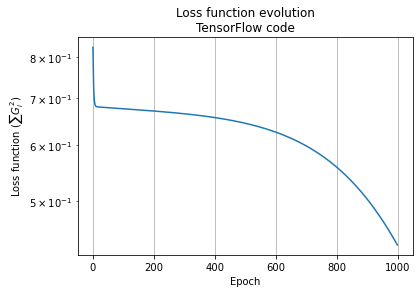

In [9]:
# Plot the loss function history.
plt.semilogy(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss function ($\sum G_i^2$)")
plt.grid()
plt.title("Loss function evolution\nTensorFlow code")
plt.show()

In [10]:
# Compute the trained solution.
with tf.GradientTape() as tape:
    N = model(xtv)
dN_dx = tape.gradient(N, xtv)
N = tf.reshape(N, (nt, 1))
dN_dx = tf.reshape(dN_dx, (nt, 1))
Ymt = 1 + xtv*N
dYmt_dx = xtv*dN_dx + N

# Compute the error in the trained solution and derivative.
err = Ymt.numpy().reshape((nt)) - Yat
derr = dYmt_dx.numpy().reshape((nt)) - dYat_dx

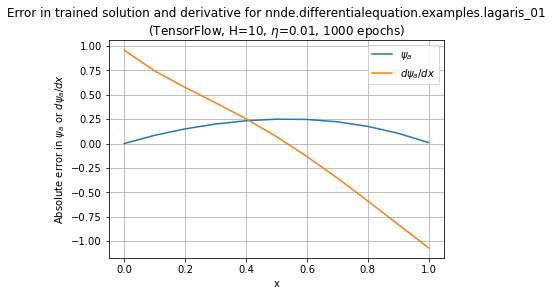

In [11]:
# Plot the errors in the trained solution and derivative.
plt.plot(xt, err, label="$\psi_a$")
plt.plot(xt, derr, label="$d\psi_a/dx$")
plt.xlabel("x")
plt.ylabel("Absolute error in $\psi_a$ or $d\psi_a/dx$")
plt.grid()
plt.legend()
plt.title("Error in trained solution and derivative for %s\n(%s, H=%s, $\eta$=%s, %s epochs)" %
         (eq_name, "TensorFlow", H, opts["eta"], opts["maxepochs"]))
plt.show()